In [13]:
from typing import Optional

import numpy as np
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from collections import defaultdict
import pickle

from pathlib import Path
from data_generation.spectral_density import arma_spectral_density
import pandas as pd

from lrv_test import LRV
from lrv_test.types import real_function

from data_generation.arma import generate_arma_sample

import seaborn as sns

sns.set_style("whitegrid")

# Limit distribution check

In [14]:
def run(
    f: real_function,
    N: int,
    M: int,
    B: int,
    ar: float,
    ma: float,
    freqs: np.ndarray,
    is_complex_gaussian: bool,
    oracle_sd: Optional[real_function] = None,
    L: Optional[int] = None,
) -> dict:
    y = generate_arma_sample(N, M, ar, ma, is_complex_gaussian)
    lrv = LRV(y, B, f, freqs=freqs, L=L, sd=oracle_sd)
    return {
        "lrv": lrv,
        "freqs": freqs,
        "ar": ar,
        "ma": ma,
        "N": N,
        "M": M,
        "B": B,
        "is_complex_gaussian": is_complex_gaussian,
        "L": L,
    }

In [15]:
N_range = np.arange(1_000, 8_000, 2_000)
N_range = [1_000, 5_000, 10_000, 20_000]
N_range = [1_000, 2_000, 5_000, 10_000]
alpha_range = np.arange(0.5, 1.0, 0.025)
c = 1 / 2

is_oracle_range = [True]  # [False, True]
is_complex_gaussian_range = [True]  # [False, True]

# Define the function / frequencies to test
f = lambda x: (x - 1) ** 2


def freqs(B, N):
    return None  # np.arange(-0.4, 0.6, B / N)


# Define once properties of the arma process to generate
ar, ma = 0.1, 0.5

# Define the number of repetitions
n_repeat = 10**2

# storage path
storage_path = Path("./plots/clt_arma_large_alpha")
storage_path.mkdir(parents=True, exist_ok=True)

In [ ]:
tasks = defaultdict(list)

for is_oracle in is_oracle_range:
    for is_complex_gaussian in is_complex_gaussian_range:
        for N in N_range:
            if is_oracle:
                oracle_sd = arma_spectral_density(ar, ma)
                L = None
            else:
                oracle_sd = None
                L = int(N**0.15)

            for alpha in alpha_range:
                M = int(N**alpha)
                B = int(M / c)
                if B % 2 == 0:
                    B += 1

                if B > N:
                    continue

                freqs_values = freqs(B, N)

                task = {
                    "f": f,
                    "freqs": freqs_values,
                    "N": N,
                    "M": M,
                    "B": B,
                    "ar": ar,
                    "ma": ma,
                    "is_complex_gaussian": is_complex_gaussian,
                    "oracle_sd": oracle_sd,
                    "L": L,
                }
                tasks[N] += [task.copy() for _ in range(n_repeat)]

len(tasks)

4

In [12]:
results = []
N0, M0, B0 = (
    N_range[0],
    int(N_range[0] ** alpha_range[0]),
    int(N_range[0] ** alpha_range[0] / c),
)
for N, task_list in tasks.items():
    # can run 10 tasks for small N, decrase as a factor of N*M
    # function: 10/(N * M)[0]
    M = task_list[0]["M"]
    B = task_list[0]["B"]
    n_cpus = int(25 * (B0 * M0 / (B * M)))
    n_cpus = max(1, n_cpus)
    n_cpus = min(10, n_cpus)
    print(
        f"Running {len(task_list)} tasks with {n_cpus} cpus: {N}, {M}, {B}, {N0}, {M0}, {B0}"
    )
    results += Parallel(n_jobs=n_cpus)(delayed(run)(**task) for task in tqdm(task_list))

# save the results with pickle
with open(storage_path / "results.pkl", "wb") as f:
    pickle.dump(results, f)

Running 1600 tasks with 10 cpus: 1000, 31, 63, 1000, 31, 63


  0%|          | 0/1600 [00:00<?, ?it/s]

 94%|█████████▍| 1510/1600 [00:13<00:01, 79.07it/s] Exception ignored in: <function ResourceTracker.__del__ at 0x1059bf380>
Traceback (most recent call last):
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x108423380>
Traceback (most recent call last):
  File "/Users/alexisrosuel/m

Running 1700 tasks with 10 cpus: 2000, 44, 89, 1000, 31, 63


100%|██████████| 1700/1700 [01:10<00:00, 24.06it/s]


Running 1700 tasks with 4 cpus: 5000, 70, 141, 1000, 31, 63


  0%|          | 0/1700 [00:00<?, ?it/s]Exception ignored in: <function ResourceTracker.__del__ at 0x108a63380>
Traceback (most recent call last):
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103e63380>
Traceback (most recent call last):
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiproc

Running 1700 tasks with 2 cpus: 10000, 100, 201, 1000, 31, 63


  0%|          | 0/1700 [00:00<?, ?it/s]Exception ignored in: <function ResourceTracker.__del__ at 0x10541b380>
Traceback (most recent call last):
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104977380>
Traceback (most recent call last):
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiproc

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6)}

In [ ]:
# load results from pickle

with open(storage_path / "results.pkl", "rb") as f:
    results = pickle.load(f)

EOFError: Ran out of input

In [ ]:
expanded_results = []

for result in results:
    lrv = result["lrv"]
    freqs_values = result["freqs"]
    ar = result["ar"]
    ma = result["ma"]
    N = result["N"]
    M = result["M"]
    B = result["B"]
    is_complex_gaussian = result["is_complex_gaussian"]
    # oracle_sd = result["oracle_sd"]
    L = result["L"]

    is_oracle = oracle_sd is not None

    # re-estimate alpha: round alpha to the closest in the alpha_range
    alpha = np.log(M) / np.log(N)
    min_idx = np.argmin(np.abs(alpha_range - alpha))
    alpha = alpha_range[min_idx]

    for t_stat in ["t_stats_0", "t_stat_1", "t_stat_2", "t_stat_3", "t_stat_4"]:
        if t_stat == "t_stats_0":
            for i, nu in enumerate(freqs_values):
                expanded_result = {
                    "lrv": getattr(lrv, t_stat)[i],
                    "lrv_stat": t_stat,
                    "freq": nu,
                    "ar": ar,
                    "ma": ma,
                    "N": N,
                    "M": M,
                    "B": B,
                    "is_complex_gaussian": is_complex_gaussian,
                    "is_oracle": is_oracle,
                    "alpha": alpha,
                }
                expanded_results.append(expanded_result)
        else:
            expanded_result = {
                "lrv": getattr(lrv, t_stat),
                "lrv_stat": t_stat,
                "nu": None,
                "ar": ar,
                "ma": ma,
                "N": N,
                "M": M,
                "B": B,
                "is_complex_gaussian": is_complex_gaussian,
                "is_oracle": is_oracle,
                "alpha": alpha,
            }
            expanded_results.append(expanded_result)

df = pd.DataFrame(expanded_results)

NameError: name 'results' is not defined

In [34]:
df

,lrv,lrv_stat,ar,ma,N,M,B,is_complex_gaussian,is_oracle,alpha
0,-110.215378,t_stat_1,0.1,0.5,2000,361,723,True,True,0.775
1,8062.706594,t_stat_2,0.1,0.5,2000,361,723,True,True,0.775
2,19752.517102,t_stat_3,0.1,0.5,2000,361,723,True,True,0.775
3,7089.784690,t_stat_4,0.1,0.5,2000,361,723,True,True,0.775
4,-1259.410061,t_stat_1,0.1,0.5,5000,1393,2787,True,True,0.850
...,...,...,...,...,...,...,...,...,...,...
26795,0.162998,t_stat_4,0.1,0.5,2000,79,159,True,True,0.575
26796,-1.264198,t_stat_1,0.1,0.5,2000,54,109,True,True,0.525
26797,-0.059499,t_stat_2,0.1,0.5,2000,54,109,True,True,0.525
26798,18.633224,t_stat_3,0.1,0.5,2000,54,109,True,True,0.525


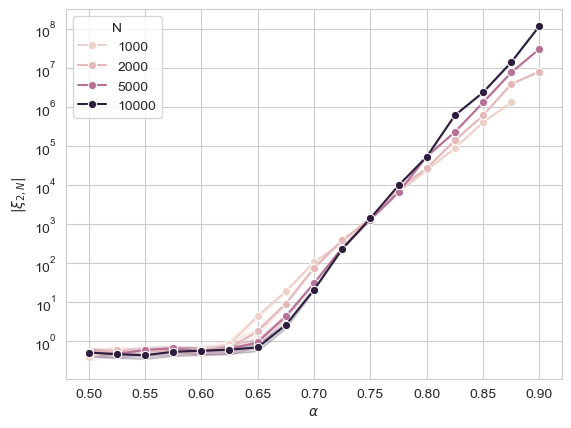

In [ ]:
fig, ax = plt.subplots()

ax.set_yscale("log")

sub_df = df[df["lrv_stat"] == "t_stat_2"]
sub_df = sub_df[sub_df["is_oracle"] == True]
sub_df = sub_df[sub_df["is_complex_gaussian"] == True]

# add a column giving the number of frequencies for each row
sub_df["n_freqs"] = sub_df.apply(lambda x: len(freqs(x["B"], x["N"])), axis=1)
sub_df["lrv_renormalized"] = sub_df["lrv"] - sub_df["n_freqs"]

sns.lineplot(
    sub_df[["alpha", "lrv", "lrv_renormalized", "is_complex_gaussian", "N"]].abs(),
    x="alpha",
    y="lrv",
    hue="N",
    errorbar=("ci", 95),
    marker="o",
    ax=ax,
)

# rename x label to r"\alpha"
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$|\xi_{2,N}|$")

# add a plot

# save fig
fig.savefig(storage_path / "clt_arma_large_alpha.png")

In [17]:
df[df["lrv_stat"] == "t_stat_2"].groupby(
    ["lrv_stat", "N", "alpha", "is_complex_gaussian", "is_oracle"]
).agg(
    mean_lrv=("lrv", "mean"),
    std_lrv=("lrv", "std"),
).reset_index()

,lrv_stat,N,alpha,is_complex_gaussian,is_oracle,mean_lrv,std_lrv
0,t_stat_2,1000,0.50,True,True,-4.290928e-01,1.169607
1,t_stat_2,1000,0.55,True,True,-3.852156e-01,0.927082
2,t_stat_2,1000,0.60,True,True,-9.178093e-03,0.806949
3,t_stat_2,1000,0.65,True,True,4.934589e+00,3.653571
4,t_stat_2,1000,0.70,True,True,1.193679e+02,17.159282
5,t_stat_2,1000,0.75,True,True,1.567690e+03,56.064881
6,t_stat_2,1000,0.80,True,True,2.378179e+04,542.596115
7,t_stat_2,1000,0.85,True,True,3.996648e+05,1374.921049
8,t_stat_2,5000,0.50,True,True,-2.069876e-02,0.777157
9,t_stat_2,5000,0.55,True,True,-1.996369e-01,0.672173


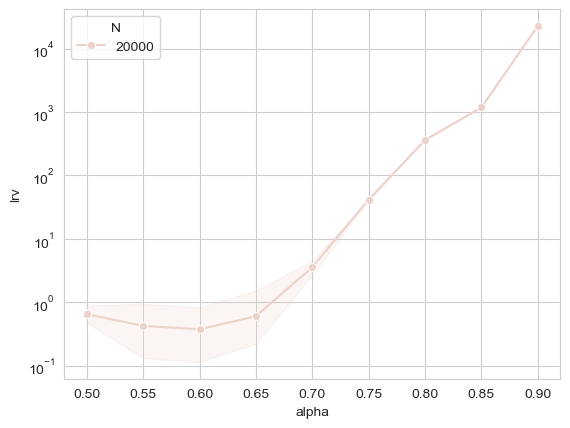

In [21]:
fig, ax = plt.subplots()

# ax.set_xscale('log')
ax.set_yscale("log")

sub_df = df[df["lrv_stat"] == "t_stat_1"]
sub_df = sub_df[sub_df["is_oracle"] == True]
sub_df = sub_df[sub_df["is_complex_gaussian"] == True]

sns.lineplot(
    sub_df[["alpha", "lrv", "is_complex_gaussian", "N"]].abs(),
    x="alpha",
    y="lrv",
    hue="N",
    errorbar=("ci", 95),
    marker="o",
    ax=ax,
)

# save fig
fig.savefig(storage_path / "clt_arma_large_alpha.png")

In [13]:
expanded_results = []

for result in results:
    lrv = result["lrv"]
    freqs = result["freqs"]
    ar = result["ar"]
    ma = result["ma"]
    N = result["N"]
    M = result["M"]
    B = result["B"]
    is_complex_gaussian = result["is_complex_gaussian"]
    # oracle_sd = result["oracle_sd"]
    L = result["L"]

    is_oracle = oracle_sd is not None

    alpha = np.log(M) / np.log(N)
    # round alpha to the closest in the alpha_range
    min_idx = np.argmin(np.abs(alpha_range - alpha))
    alpha = alpha_range[min_idx]

    for i, nu in enumerate(freqs):
        expanded_result = {
            "lrv": lrv.t_stat_1[i],
            "lrv_stat": "t_stat_1",
            "ar": ar,
            "ma": ma,
            "N": N,
            "M": M,
            "B": B,
            "is_complex_gaussian": is_complex_gaussian,
            "is_oracle": is_oracle,
            "alpha": alpha,
            "nu": nu,
        }
        expanded_results.append(expanded_result)

df = pd.DataFrame(expanded_results)

IndexError: invalid index to scalar variable.

In [14]:
lrv.t_stat_1

np.float64(0.1826587637147604)

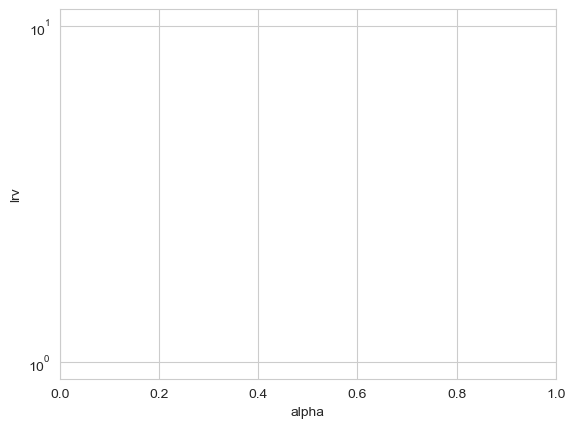

In [12]:
fig, ax = plt.subplots()

# ax.set_xscale('log')
ax.set_yscale("log")

sub_df = df[df["lrv_stat"] == "t_stat_1"]
sub_df = sub_df[sub_df["is_oracle"] == True]
sub_df = sub_df[sub_df["is_complex_gaussian"] == True]

sns.lineplot(
    sub_df[["alpha", "lrv", "is_complex_gaussian", "N"]].abs(),
    x="alpha",
    y="lrv",
    hue="N",
    errorbar=("ci", 95),
    marker="o",
    ax=ax,
)

# save fig
fig.savefig(storage_path / "clt_arma_large_alpha.png")

In [5]:
from tqdm import tqdm
from joblib import Parallel, delayed
import numpy as np


def sim():
    # run a dice 24 times. Return 1 if at least once we have two consecutive 6
    # otherwise return 0
    previous = None
    for i in range(24):
        # roll the dice
        current = np.random.randint(1, 7)
        if previous == 6 and current == 6:
            return 1
        previous = current

    return 0


# run the simulation 10**6 times
n_sim = 10**6
results = Parallel(n_jobs=-1)(delayed(sim)() for _ in tqdm(range(n_sim)))

# compute the proportion of success
proportion = np.mean(results)
print(f"Proportion of success: {proportion}")

# compute the estimated standard deviation of the proportion
std_proportion = np.std(results) / np.sqrt(n_sim)
print(f"Estimated standard deviation of the proportion: {std_proportion}")

100%|██████████| 1000000/1000000 [00:04<00:00, 234528.02it/s]


Proportion of success: 0.43355
Estimated standard deviation of the proportion: 0.0004955647258431537


Exception ignored in: <function ResourceTracker.__del__ at 0x104d7f380>
Traceback (most recent call last):
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107e17380>
Traceback (most recent call last):
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/alexisrosuel/micromamba/envs/lrv313/lib/python3.13/multiprocessing/resource_tracker.py", line 116, i